### **1. Generate XSLX**

In [5]:
"""
Outputs:
- group4_Lab1.xlsx with sheets:
  motion1_head, motion1_neck,
  motion2_rightshoulder, motion2_rightarm, motion2_rightforearm, motion2_righthand,
  offsets, meta
"""

from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd


# ---------------------------
# BVH parsing
# ---------------------------
def parse_bvh(bvh_path: str | Path):
    """
    Returns:
      joints: list[str]          (joint names encountered)
      offsets: np.ndarray        shape (num_joints, 3) - excludes End Sites by design here
      labels: list[str]          channel labels in column order, like 'Head_Xrotation'
      motion: np.ndarray         shape (frames, channels)
      frame_time: float          seconds
    """
    bvh_path = Path(bvh_path)

    with bvh_path.open("r", encoding="utf-8", errors="ignore") as f:
        lines = f.read().splitlines()

    # Split into hierarchy and motion sections
    try:
        motion_idx = next(i for i, l in enumerate(lines) if l.strip() == "MOTION")
    except StopIteration:
        raise ValueError(f"No MOTION section found in {bvh_path}")

    hier_lines = lines[:motion_idx]
    mot_lines = lines[motion_idx + 1 :]

    # Parse Frames and Frame Time
    frames_line = next((l for l in mot_lines if l.strip().startswith("Frames:")), None)
    ft_line = next((l for l in mot_lines if l.strip().startswith("Frame Time:")), None)
    if frames_line is None or ft_line is None:
        raise ValueError(f"Missing 'Frames:' or 'Frame Time:' in {bvh_path}")

    n_frames = int(frames_line.split(":")[1].strip())
    frame_time = float(ft_line.split(":")[1].strip())

    ft_idx = mot_lines.index(ft_line)
    data_lines = mot_lines[ft_idx + 1 : ft_idx + 1 + n_frames]
    if len(data_lines) != n_frames:
        raise ValueError(
            f"Expected {n_frames} frame rows, got {len(data_lines)} in {bvh_path}"
        )

    # Parse hierarchy: joint names, offsets, and channel labels
    joint_stack: list[str] = []
    joints: list[str] = []
    offsets: list[list[float]] = []
    labels: list[str] = []

    for raw in hier_lines:
        line = raw.strip()

        if line.startswith(("ROOT", "JOINT")):
            # joint names can contain spaces (rare, but safe)
            jname = " ".join(line.split()[1:])
            joint_stack.append(jname)
            joints.append(jname)

        elif line.startswith("OFFSET"):
            # OFFSETS exist for ROOT/JOINT blocks and also for End Site blocks.
            # This parser only appends offsets when we are inside a real joint block,
            # and ignores End Sites because End Sites are not pushed to joint_stack.
            parts = line.split()
            if len(parts) < 4:
                raise ValueError(f"Bad OFFSET line in {bvh_path}: {raw}")
            if joint_stack:
                offsets.append([float(parts[1]), float(parts[2]), float(parts[3])])

        elif line.startswith("CHANNELS"):
            parts = line.split()
            if len(parts) < 3:
                raise ValueError(f"Bad CHANNELS line in {bvh_path}: {raw}")
            k = int(parts[1])
            chans = parts[2 : 2 + k]
            if not joint_stack:
                raise ValueError(f"CHANNELS outside joint block in {bvh_path}: {raw}")
            jname = joint_stack[-1]
            labels.extend([f"{jname}_{c}" for c in chans])

        elif line == "}":
            if joint_stack:
                joint_stack.pop()

    offsets_arr = np.asarray(offsets, dtype=float)

    # Parse motion numeric matrix
    num_channels = len(labels)
    flat = np.fromstring("\n".join(data_lines), sep=" ")
    if flat.size != n_frames * num_channels:
        raise ValueError(
            f"Data size mismatch in {bvh_path}: "
            f"got {flat.size} floats, expected {n_frames * num_channels} "
            f"({n_frames} frames * {num_channels} channels)."
        )
    motion = flat.reshape((n_frames, num_channels))

    return joints, offsets_arr, labels, motion, frame_time


def slice_joint(motion: np.ndarray, labels: list[str], joint_name: str):
    """Return (cols, data, colnames) for all channels belonging to joint_name."""
    prefix = joint_name + "_"
    cols = [i for i, lab in enumerate(labels) if lab.startswith(prefix)]
    if not cols:
        unique_joints = sorted({lab.split("_", 1)[0] for lab in labels})
        raise ValueError(
            f"No channels found for joint '{joint_name}'. "
            f"Available joints include: {', '.join(unique_joints[:30])}"
            + (" ..." if len(unique_joints) > 30 else "")
        )
    colnames = [labels[i] for i in cols]
    data = motion[:, cols]
    return cols, data, colnames


# ---------------------------
# Main: generate Excel
# ---------------------------
def main():
    motion1_bvh = Path("motion_1_all.bvh")
    motion2_bvh = Path("motion_2_all.bvh")
    out_xlsx = Path("group4_Lab1.xlsx")

    # Parse BVHs
    joints1, offsets1, labels1, motion1_all, dt1 = parse_bvh(motion1_bvh)
    joints2, offsets2, labels2, motion2_all, dt2 = parse_bvh(motion2_bvh)

    # Required joint extracts (sheet_name, motion, labels, joint_name)
    extracts = [
        ("motion1_head", motion1_all, labels1, "Head"),
        ("motion1_neck", motion1_all, labels1, "Neck"),
        ("motion2_rightshoulder", motion2_all, labels2, "RightShoulder"),
        ("motion2_rightarm", motion2_all, labels2, "RightArm"),
        ("motion2_rightforearm", motion2_all, labels2, "RightForeArm"),
        ("motion2_righthand", motion2_all, labels2, "RightHand"),
    ]

    # Write workbook
    with pd.ExcelWriter(out_xlsx, engine="openpyxl") as writer:
        for sheet, mot, labs, joint in extracts:
            _, data, colnames = slice_joint(mot, labs, joint)
            pd.DataFrame(data, columns=colnames).to_excel(writer, sheet_name=sheet, index=False)

        # Offsets (lab wants 72x3 matrix called offsets; writing to a sheet is convenient)
        pd.DataFrame(offsets1, columns=["x", "y", "z"]).to_excel(writer, sheet_name="offsets", index=False)

        # Meta (optional, but useful)
        meta = pd.DataFrame(
            {
                "item": [
                    "motion1_frames",
                    "motion1_dt",
                    "motion1_channels",
                    "motion2_frames",
                    "motion2_dt",
                    "motion2_channels",
                    "offsets_shape",
                ],
                "value": [
                    motion1_all.shape[0],
                    dt1,
                    motion1_all.shape[1],
                    motion2_all.shape[0],
                    dt2,
                    motion2_all.shape[1],
                    f"{offsets1.shape}",
                ],
            }
        )
        meta.to_excel(writer, sheet_name="meta", index=False)

    # Ouput summary
    print(f"Wrote: {out_xlsx.resolve()}")
    print(f"motion1_all shape: {motion1_all.shape}, dt={dt1}")
    print(f"motion2_all shape: {motion2_all.shape}, dt={dt2}")
    print(f"offsets shape: {offsets1.shape}")
    print("Sheets:", [s[0] for s in extracts] + ["offsets", "meta"])


if __name__ == "__main__":
    main()


Wrote: C:\Users\conno\Documents\DEVELOPMENT\BME551\lab_1\group4_Lab1.xlsx
motion1_all shape: (1458, 354), dt=0.008
motion2_all shape: (1212, 354), dt=0.008
offsets shape: (72, 3)
Sheets: ['motion1_head', 'motion1_neck', 'motion2_rightshoulder', 'motion2_rightarm', 'motion2_rightforearm', 'motion2_righthand', 'offsets', 'meta']


### **2. Validate it using python library**

In [16]:
import bvhio
# Loads the file into a deserialized tree structure.
bvh = bvhio.readAsBvh('motion_1_all.bvh')

# Create a mapping of the motion vector
motion_vector_mapping = []
i = 0
for joint, index, depth in bvh.Root.layout():
    for channel in joint.Channels:
        motion_vector_mapping.append([f"{joint.Name}_{channel}", i])
        i += 1

print(motion_vector_mapping)

# Testing the vector data we have
test_line = "-4.287181 94.400337 -8.529825 -152.219925 1.480777 0.603178 -9.241459 -1.590356 0.004106 -5.485950 4.399758 -1.303315 0.017791 -41.874123 0.037714 0.139742 -3.045583 1.368544 0.093230 -41.716553 -0.487128 3.538646 -3.380773 -0.227800 9.270742 -1.592649 0.015414 2.554568 5.594737 -2.420373 0.047357 -41.876572 -0.006554 0.665250 -3.344392 2.333238 -0.127509 -42.006424 0.263827 -0.345711 -4.054052 -1.389855 0.002296 14.306973 0.025947 -0.701089 -1.474961 -0.682882 0.003817 9.718307 0.011655 -0.174029 -0.368628 -0.172405 0.007844 10.119958 0.009640 -0.286538 -0.615072 -0.286689 0.007450 9.718678 0.009851 0.115980 0.092201 -0.002526 0.007100 10.387465 0.010609 0.116366 0.092243 -0.002525 0.004438 9.470020 0.023169 2.094610 1.669949 -0.016630 -3.195220 6.900340 0.003781 5.253528 2.860694 0.904739 -12.755801 -0.026013 -0.020932 6.930975 -1.146868 84.418549 -26.498936 -0.068051 -0.007257 3.861060 17.381273 1.992201 -25.997698 -0.041198 0.006490 -2.065007 6.086652 0.985493 -2.489053 0.190105 3.120527 21.860001 -0.000000 30.000000 -3.682737 0.000000 0.000000 -10.000000 -0.000000 0.000000 -2.558316 0.000000 0.000000 -10.000000 -0.000000 0.000000 -3.223684 0.508421 1.978421 0.000000 -0.000000 0.000000 -5.216842 -0.091368 0.999158 2.550000 -0.000000 20.000000 -3.619368 0.000000 0.000000 0.000000 -0.000000 24.000000 -2.052105 0.000000 0.000000 0.000000 -0.000000 20.000000 -3.382106 0.517263 0.756737 0.000000 -0.000000 0.000000 -5.174105 -0.084000 0.313895 0.000000 -0.000000 20.000000 -3.949473 0.000000 0.000000 0.000000 -0.000000 24.000000 -2.475789 0.000000 0.000000 0.000000 -0.000000 20.000000 -3.365158 0.537895 -0.128947 0.000000 -0.000000 0.000000 -4.634737 -0.022105 -0.478947 -3.000000 -0.000000 20.000000 -3.442379 0.000000 0.000000 0.000000 -0.000000 24.000000 -2.388105 0.000000 0.000000 0.000000 -0.000000 20.000000 -3.161053 0.469368 -1.201789 0.000000 -0.000000 0.000000 -4.141052 -0.022105 -1.090526 -8.830000 -0.000000 20.000000 -2.756526 0.000000 0.000000 0.000000 -0.000000 24.000000 -1.741895 0.000000 0.000000 0.000000 -0.000000 20.000000 3.205112 6.925927 -0.010023 2.639375 0.759340 -2.377066 12.805068 0.004518 -0.046735 -9.292546 -3.318863 -78.614494 26.485937 0.000979 -0.060685 -1.680737 21.560532 -2.327437 25.999374 -0.019366 -0.044268 4.626154 0.680836 -4.879169 2.489053 0.190105 3.120527 -21.860001 -0.000000 -30.000000 3.682737 0.000000 0.000000 10.000000 -0.000000 0.000000 2.558316 0.000000 0.000000 10.000000 -0.000000 0.000000 3.223684 0.508421 1.978421 0.000000 -0.000000 0.000000 5.216842 -0.091368 0.999158 -2.550000 -0.000000 -20.000000 3.619368 0.000000 0.000000 0.000000 -0.000000 -24.000000 2.052105 0.000000 0.000000 0.000000 -0.000000 -20.000000 3.382106 0.517263 0.756737 0.000000 -0.000000 0.000000 5.174105 -0.084000 0.313895 0.000000 -0.000000 -20.000000 3.949473 0.000000 0.000000 0.000000 -0.000000 -24.000000 2.475789 0.000000 0.000000 0.000000 -0.000000 -20.000000 3.365158 0.537895 -0.128947 0.000000 -0.000000 0.000000 4.634737 -0.022105 -0.478947 3.000000 -0.000000 -20.000000 3.442379 0.000000 0.000000 0.000000 -0.000000 -24.000000 2.388105 0.000000 0.000000 0.000000 -0.000000 -20.000000 3.161053 0.469368 -1.201789 0.000000 -0.000000 0.000000 4.141052 -0.022105 -1.090526 8.830000 -0.000000 -20.000000 2.756526 0.000000 0.000000 0.000000 -0.000000 -24.000000 1.741895 0.000000 0.000000 0.000000 -0.000000 -20.000000"

test_array_length = len(test_line.split(" "))
print(f"Test line has {test_array_length} values, expected {len(motion_vector_mapping)}")

# Find indice of the head and neck channels in the motion vector mapping
head_indices = [idx for name, idx in motion_vector_mapping if name.startswith("Head_")]
neck_indices = [idx for name, idx in motion_vector_mapping if name.startswith("Neck_")]

print("Head indices:", head_indices)
print("Neck indices:", neck_indices)

# Read from motion1.txt for the head data by importing the motion vector and using the mapping
import numpy as np

# Read motion1.txt and convert to array
with open('motion1.txt', 'r') as f:
    lines = f.readlines()

# Split each line by space and convert to floats
motion1_array = np.array([line.strip().split() for line in lines], dtype=float)

print(f"Motion1 array shape: {motion1_array.shape}")
print(f"Number of frames: {motion1_array.shape[0]}")
print(f"Number of channels: {motion1_array.shape[1]}")

# Extract head x position data
head_x_data = motion1_array[:, head_indices[0]]  # Assuming the first head channel is x position
print("Head X position data:", head_x_data)



[['Hips_Xposition', 0], ['Hips_Yposition', 1], ['Hips_Zposition', 2], ['Hips_Yrotation', 3], ['Hips_Xrotation', 4], ['Hips_Zrotation', 5], ['RightUpLeg_Xposition', 6], ['RightUpLeg_Yposition', 7], ['RightUpLeg_Zposition', 8], ['RightUpLeg_Yrotation', 9], ['RightUpLeg_Xrotation', 10], ['RightUpLeg_Zrotation', 11], ['RightLeg_Xposition', 12], ['RightLeg_Yposition', 13], ['RightLeg_Zposition', 14], ['RightLeg_Yrotation', 15], ['RightLeg_Xrotation', 16], ['RightLeg_Zrotation', 17], ['RightFoot_Xposition', 18], ['RightFoot_Yposition', 19], ['RightFoot_Zposition', 20], ['RightFoot_Yrotation', 21], ['RightFoot_Xrotation', 22], ['RightFoot_Zrotation', 23], ['LeftUpLeg_Xposition', 24], ['LeftUpLeg_Yposition', 25], ['LeftUpLeg_Zposition', 26], ['LeftUpLeg_Yrotation', 27], ['LeftUpLeg_Xrotation', 28], ['LeftUpLeg_Zrotation', 29], ['LeftLeg_Xposition', 30], ['LeftLeg_Yposition', 31], ['LeftLeg_Zposition', 32], ['LeftLeg_Yrotation', 33], ['LeftLeg_Xrotation', 34], ['LeftLeg_Zrotation', 35], ['LeftF

Code has been validated manually

### **3. Part 1 Code**

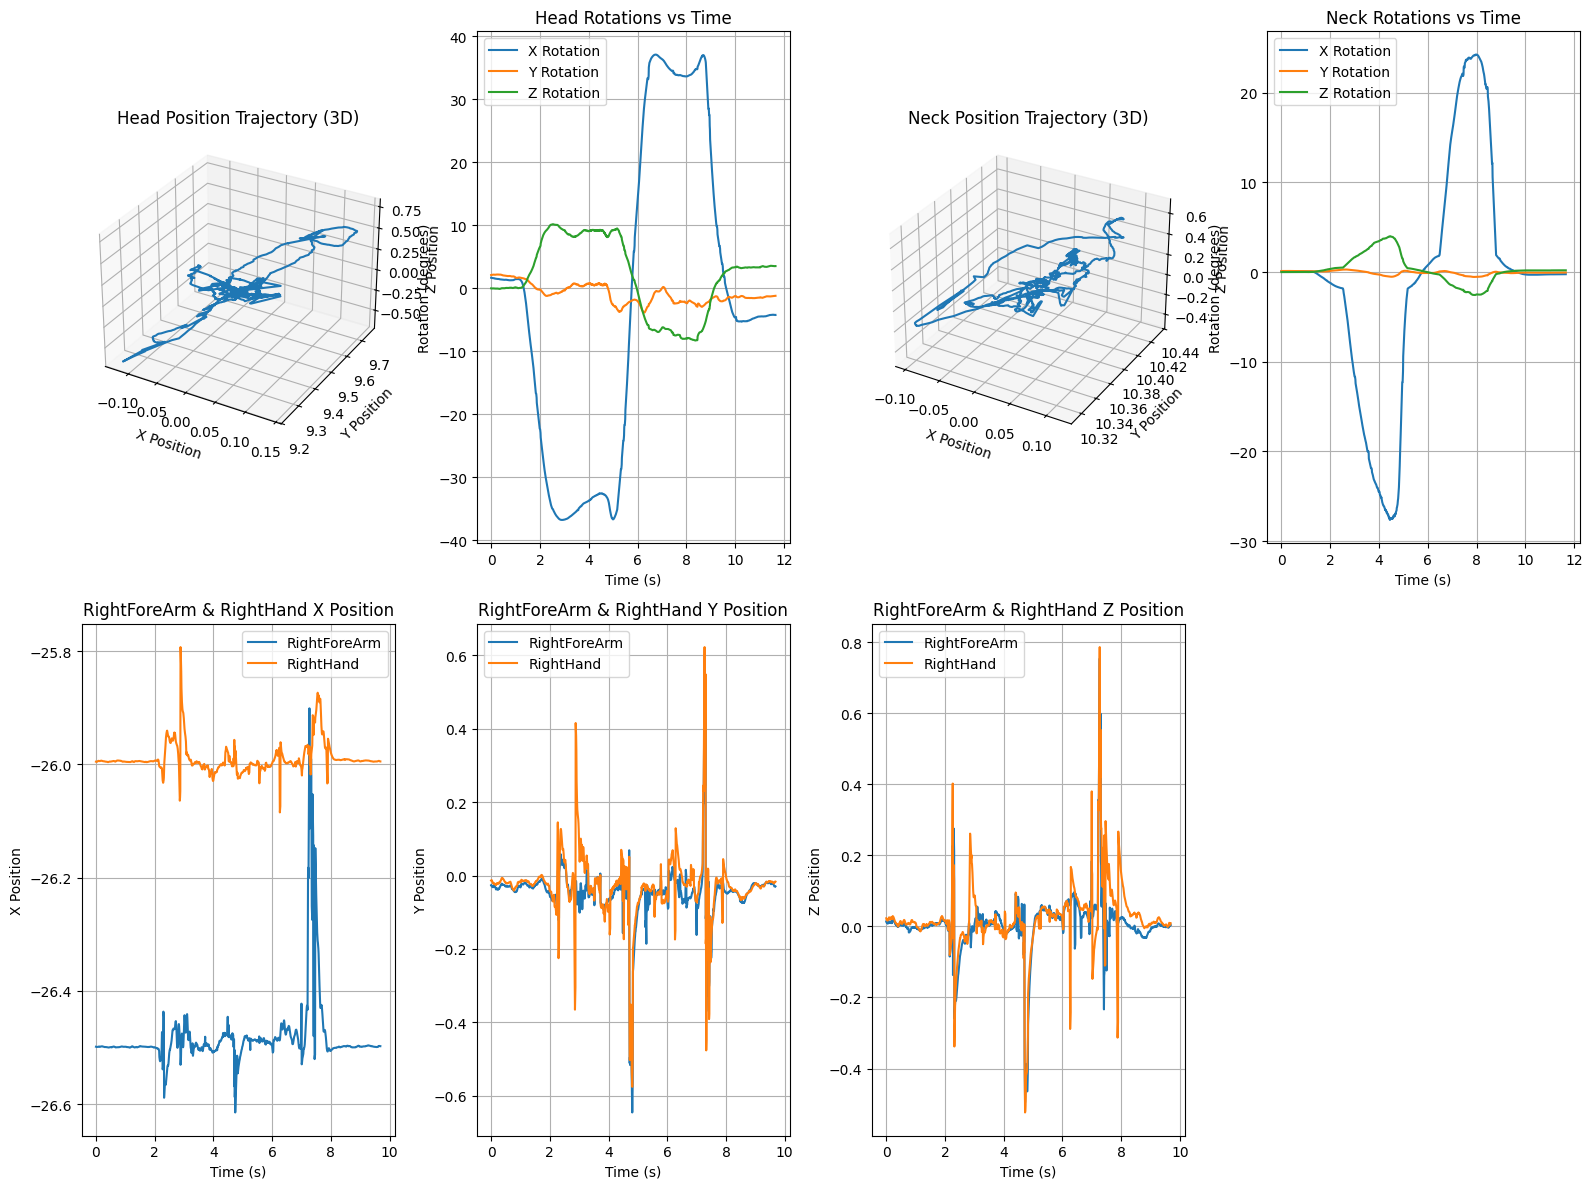

Plots saved as 'motion_plots.png'


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

# Use the same parse_bvh function from your existing code
def parse_bvh(bvh_path):
    """Parse BVH file and return joints, offsets, labels, motion, frame_time"""
    bvh_path = Path(bvh_path)
    with bvh_path.open("r", encoding="utf-8", errors="ignore") as f:
        lines = f.read().splitlines()
    
    motion_idx = next(i for i, l in enumerate(lines) if l.strip() == "MOTION")
    hier_lines = lines[:motion_idx]
    mot_lines = lines[motion_idx + 1:]
    
    frames_line = next((l for l in mot_lines if l.strip().startswith("Frames:")), None)
    ft_line = next((l for l in mot_lines if l.strip().startswith("Frame Time:")), None)
    
    n_frames = int(frames_line.split(":")[1].strip())
    frame_time = float(ft_line.split(":")[1].strip())
    
    ft_idx = mot_lines.index(ft_line)
    data_lines = mot_lines[ft_idx + 1: ft_idx + 1 + n_frames]
    
    joint_stack = []
    joints = []
    offsets = []
    labels = []
    
    for raw in hier_lines:
        line = raw.strip()
        if line.startswith(("ROOT", "JOINT")):
            jname = " ".join(line.split()[1:])
            joint_stack.append(jname)
            joints.append(jname)
        elif line.startswith("OFFSET"):
            parts = line.split()
            if joint_stack:
                offsets.append([float(parts[1]), float(parts[2]), float(parts[3])])
        elif line.startswith("CHANNELS"):
            parts = line.split()
            k = int(parts[1])
            chans = parts[2:2+k]
            jname = joint_stack[-1]
            labels.extend([f"{jname}_{c}" for c in chans])
        elif line == "}":
            if joint_stack:
                joint_stack.pop()
    
    offsets_arr = np.asarray(offsets, dtype=float)
    num_channels = len(labels)
    flat = np.fromstring("\n".join(data_lines), sep=" ")
    motion = flat.reshape((n_frames, num_channels))
    
    return joints, offsets_arr, labels, motion, frame_time

def get_joint_data(motion, labels, joint_name):
    """Extract all channels for a specific joint"""
    prefix = joint_name + "_"
    cols = [i for i, lab in enumerate(labels) if lab.startswith(prefix)]
    colnames = [labels[i] for i in cols]
    data = motion[:, cols]
    return data, colnames

# Parse motion files
joints1, offsets1, labels1, motion1, dt1 = parse_bvh('motion_1_all.bvh')
joints2, offsets2, labels2, motion2, dt2 = parse_bvh('motion_2_all.bvh')

# Extract data
head_data, head_cols = get_joint_data(motion1, labels1, "Head")
neck_data, neck_cols = get_joint_data(motion1, labels1, "Neck")
rightforearm_data, rightforearm_cols = get_joint_data(motion2, labels2, "RightForeArm")
righthand_data, righthand_cols = get_joint_data(motion2, labels2, "RightHand")

# Create time arrays
time1 = np.arange(motion1.shape[0]) * dt1
time2 = np.arange(motion2.shape[0]) * dt2

# Helper to find column indices
def get_channel_idx(colnames, channel_type):
    """Find index of channel (e.g., 'Xposition', 'Xrotation')"""
    for i, name in enumerate(colnames):
        if channel_type in name:
            return i
    return None

# Create figure with all plots
fig = plt.figure(figsize=(16, 12))

# a) Head x,y,z position 3D plot
ax1 = fig.add_subplot(2, 4, 1, projection='3d')
x_idx = get_channel_idx(head_cols, 'Xposition')
y_idx = get_channel_idx(head_cols, 'Yposition')
z_idx = get_channel_idx(head_cols, 'Zposition')
ax1.plot(head_data[:, x_idx], head_data[:, y_idx], head_data[:, z_idx])
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.set_zlabel('Z Position')
ax1.set_title('Head Position Trajectory (3D)')

# b) Head x,y,z rotations vs time
ax2 = fig.add_subplot(2, 4, 2)
xrot_idx = get_channel_idx(head_cols, 'Xrotation')
yrot_idx = get_channel_idx(head_cols, 'Yrotation')
zrot_idx = get_channel_idx(head_cols, 'Zrotation')
ax2.plot(time1, head_data[:, xrot_idx], label='X Rotation')
ax2.plot(time1, head_data[:, yrot_idx], label='Y Rotation')
ax2.plot(time1, head_data[:, zrot_idx], label='Z Rotation')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Rotation (degrees)')
ax2.set_title('Head Rotations vs Time')
ax2.legend()
ax2.grid(True)

# c) Neck x,y,z position 3D plot
ax3 = fig.add_subplot(2, 4, 3, projection='3d')
x_idx = get_channel_idx(neck_cols, 'Xposition')
y_idx = get_channel_idx(neck_cols, 'Yposition')
z_idx = get_channel_idx(neck_cols, 'Zposition')
ax3.plot(neck_data[:, x_idx], neck_data[:, y_idx], neck_data[:, z_idx])
ax3.set_xlabel('X Position')
ax3.set_ylabel('Y Position')
ax3.set_zlabel('Z Position')
ax3.set_title('Neck Position Trajectory (3D)')

# d) Neck x,y,z rotations vs time
ax4 = fig.add_subplot(2, 4, 4)
xrot_idx = get_channel_idx(neck_cols, 'Xrotation')
yrot_idx = get_channel_idx(neck_cols, 'Yrotation')
zrot_idx = get_channel_idx(neck_cols, 'Zrotation')
ax4.plot(time1, neck_data[:, xrot_idx], label='X Rotation')
ax4.plot(time1, neck_data[:, yrot_idx], label='Y Rotation')
ax4.plot(time1, neck_data[:, zrot_idx], label='Z Rotation')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Rotation (degrees)')
ax4.set_title('Neck Rotations vs Time')
ax4.legend()
ax4.grid(True)

# e) RightForeArm and RightHand X position
ax5 = fig.add_subplot(2, 4, 5)
x_idx_fa = get_channel_idx(rightforearm_cols, 'Xposition')
x_idx_h = get_channel_idx(righthand_cols, 'Xposition')
ax5.plot(time2, rightforearm_data[:, x_idx_fa], label='RightForeArm')
ax5.plot(time2, righthand_data[:, x_idx_h], label='RightHand')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('X Position')
ax5.set_title('RightForeArm & RightHand X Position')
ax5.legend()
ax5.grid(True)

# f) RightForeArm and RightHand Y position
ax6 = fig.add_subplot(2, 4, 6)
y_idx_fa = get_channel_idx(rightforearm_cols, 'Yposition')
y_idx_h = get_channel_idx(righthand_cols, 'Yposition')
ax6.plot(time2, rightforearm_data[:, y_idx_fa], label='RightForeArm')
ax6.plot(time2, righthand_data[:, y_idx_h], label='RightHand')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Y Position')
ax6.set_title('RightForeArm & RightHand Y Position')
ax6.legend()
ax6.grid(True)

# g) RightForeArm and RightHand Z position
ax7 = fig.add_subplot(2, 4, 7)
z_idx_fa = get_channel_idx(rightforearm_cols, 'Zposition')
z_idx_h = get_channel_idx(righthand_cols, 'Zposition')
ax7.plot(time2, rightforearm_data[:, z_idx_fa], label='RightForeArm')
ax7.plot(time2, righthand_data[:, z_idx_h], label='RightHand')
ax7.set_xlabel('Time (s)')
ax7.set_ylabel('Z Position')
ax7.set_title('RightForeArm & RightHand Z Position')
ax7.legend()
ax7.grid(True)

plt.tight_layout()
plt.savefig('motion_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plots saved as 'motion_plots.png'")

### **4. Part 3 code**

In [1]:
import re, pandas as pd

path="motion_1_all.bvh"
with open(path,"r") as f:
    text=f.read()

# Split header and motion
header, motion = text.split("MOTION")
header_lines=header.splitlines()

joint_stack=[]
channels=[]
joint_channels={}
for line in header_lines:
    if "ROOT" in line or "JOINT" in line:
        name=line.split()[1]
        joint_stack.append(name)
    if "End Site" in line:
        joint_stack.append("End")
    if "}" in line:
        if joint_stack: joint_stack.pop()
    if "CHANNELS" in line:
        parts=line.split()
        n=int(parts[1])
        ch=parts[2:2+n]
        joint=joint_stack[-1]
        joint_channels.setdefault(joint,[]).extend(ch)
        for c in ch:
            channels.append((joint,c))

motion_lines=[l.strip() for l in motion.splitlines() if re.match(r"^[\d\-\.\s]+$",l)]
frames=[list(map(float,l.split())) for l in motion_lines]
df=pd.DataFrame(frames,columns=[f"{j}_{c}" for j,c in channels])

def get_peak(joint):
    cols=[c for c in df.columns if c.startswith(joint) and "rotation" in c.lower()]
    xcol=[c for c in cols if "Xrotation" in c][0]
    series=df[xcol]
    return series.min(), series.max()

results={}
for joint in ["Head","Neck","neck","head"]:
    if any(c.startswith(joint+"_") for c in df.columns):
        results[joint]=get_peak(joint)

print(results)

{'Head': (-36.791553, 37.09985), 'Neck': (-27.632259, 24.238506)}
